# Test the fully parallel propagation of the Rydberg Hamiltonian

This uses the standard "multiprocessor scheduling algorithm" to balance the operator sizes as much as possible, but makes the operators quite disjunct.  We only use 2 threads here, both in splitting the Hamiltonian, and in OMP_NUM_THREADS

In [1]:
from pathlib import Path

In [2]:
import qutip
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse

In [3]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.plots import show_spy, plot_population
from src.blocksplitting import split_AB, split_AB_blocks, split_diagonal_hamiltonian
from src.ham import rydberg_hamiltonian

In [4]:
%matplotlib inline

In [5]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [6]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET
N_THREADS = 2  # number of cores on the machine

In [7]:
H = rydberg_hamiltonian(
    N_HILBERT,
    'data/ham_drift.dat',
    'data/ham_sig.dat',
    'data/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data/pulse_sig.dat')
)

In [8]:
pulse = Pulse.read('./data/pulse_sig.dat')

In [9]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

In [10]:
A, B = split_AB_blocks(
    H[1][0].data,
    block_info=np.genfromtxt("./data/n_states_red_block.dat", dtype=np.int32),
    n=N_HILBERT,
    as_qobj=True,
)

In [11]:
def distribute_zigzag(list_of_blocks, n_threads):
    """Standard Multiprocessor scheduling algorithm"""
    thread_bins = [[] for _ in range(n_threads)]
    thread_filled = np.array([0 for _ in range(n_threads)])
    sorted_list_of_blocks = sorted(
        list_of_blocks, key=lambda block: block.data.nnz, reverse=True
    )
    for block in sorted_list_of_blocks:
        i_thread = np.argmin(thread_filled)
        thread_bins[i_thread].append(block)
        thread_filled[i_thread] += block.data.nnz
    return thread_bins

In [12]:
A_thread_bins = distribute_zigzag(A, N_THREADS)

In [13]:
[sum(op.data.nnz for op in bin) for bin in A_thread_bins]

[23226, 23226]

In [14]:
A_thread_ops = [sum(bin) for bin in A_thread_bins]

In [15]:
B_thread_bins = distribute_zigzag(B, N_THREADS)

In [16]:
[sum(op.data.nnz for op in bin) for bin in B_thread_bins]

[23226, 23226]

In [17]:
B_thread_ops = [sum(bin) for bin in B_thread_bins]

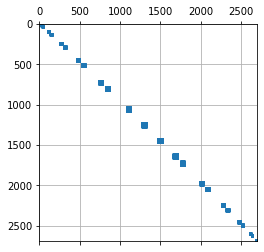

In [18]:
show_spy(A_thread_ops[1].data, show_diagonal=False, grid=True)

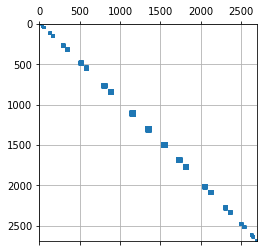

In [19]:
show_spy(B_thread_ops[0].data, show_diagonal=False, grid=True)

In [20]:
qdyn_model = LevelModel()

In [21]:
schedule_fmt = "{row},{col},%s,5" % N_THREADS

In [22]:
for (i, H0) in enumerate(split_diagonal_hamiltonian(H[0], N_THREADS)):
    qdyn_model.add_ham(
        H0,
        op_unit='au',
        op_type='pot',
        schedule=schedule_fmt.format(row=(i + 1), col=1),
    )

In [23]:
for (i, op) in enumerate(A_thread_ops):
    qdyn_model.add_ham(
        op,
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        schedule=schedule_fmt.format(row=(i + 1), col=2),
    )

In [24]:
for (i, op) in enumerate(B_thread_ops):
    qdyn_model.add_ham(
        op,
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        schedule=schedule_fmt.format(row=(i + 1), col=3),
    )

In [25]:
for (i, op) in enumerate(A_thread_ops):
    qdyn_model.add_ham(
        op.dag(),
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        conjg_pulse=True,
        schedule=schedule_fmt.format(row=(i + 1), col=4),
    )

In [26]:
for (i, op) in enumerate(B_thread_ops):
    qdyn_model.add_ham(
        op.dag(),
        pulse=H[1][1],
        op_unit='au',
        op_type='dip',
        conjg_pulse=True,
        schedule=schedule_fmt.format(row=(i + 1), col=5),
    )

In [27]:
qdyn_model.add_state(psi0, label='initial')

In [28]:
qdyn_model.add_state(psi_target, label='target')

In [29]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [30]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [31]:
RF = './rf_parallel_schedule_zigzag_2threads'

In [32]:
qdyn_model.write_to_runfolder(RF)

In [33]:
%%bash -s "$RF"
qdyn_prop_traj --version
time OMP_NUM_THREADS=2 qdyn_prop_traj --state-label=initial $1

QDYN 2.0dev revision 2b2fa92f1a71e2a8d932a667b7980c5428c8cce7 (rydbergparallel)
  features: no-check-cheby, no-check-newton, parallel-ham=DISJUNCT_COLUMN, use-mkl=false, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Sat Aug 24 05:55:09 2019 on host katamon
***** START OF PROGRAM qdyn_prop_traj ******
Sat Aug 24 20:21:25 +0200 2019

*** Read config file ./rf_parallel_schedule_zigzag_2threads/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
    1 pulses in config file
    Initializing pulse 1
  *** Initializing dynamical generator ***
*** Done with initialization ***

Completed traj 1/1 in proc 1/1
Writing avg in proc 1/1

1

real	0m35.191s
user	1m8.888s
sys	0m0.548s


In [34]:
pop_data = np.genfromtxt((Path(RF) / 'population.dat')).transpose()

In [35]:
pop_data_baseline = np.genfromtxt('./rf_baseline/population.dat').transpose()

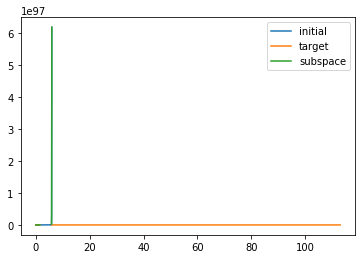

In [36]:
plot_population(pop_data)